# <font color=darkcyan> Logistic regression</font>

In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Required packages
np.set_printoptions(precision=2) 
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns
import types

### <font color=darkred>  Model </font>

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ The sigmoid function is a model choice to map $\mathbb{R}$ into $(0,1)$.


In [4]:
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples)
    return X, y

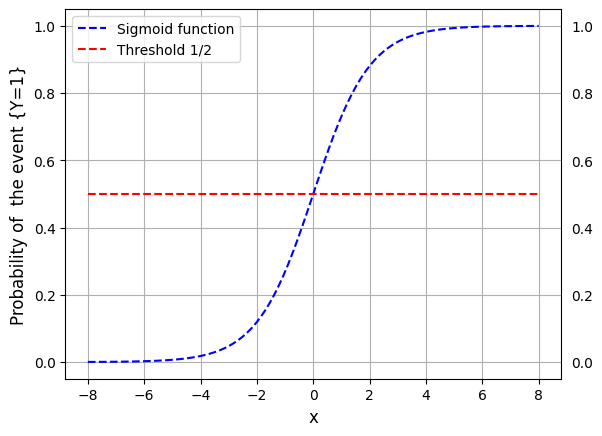

In [5]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(x,z,linestyle = "dashed",color="blue", label= "Sigmoid function")
plt.plot(x,.5*np.ones(np.size(x)),linestyle = "dashed",color="red", label="Threshold 1/2")
plt.ylabel('Probability of  the event {Y=1}', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle)\,,
\end{equation*}

The graph above illustrates that the Bayes classification rule in this case is
$f^*(X) = 1$ if and only if $\langle w,X \rangle>0$.

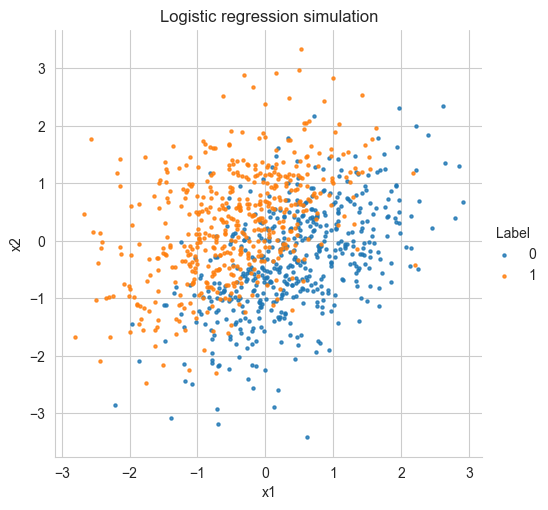

In [6]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,1], np.eye(2))

X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.3)

simulated_data          = pd.DataFrame(columns = ["x","y","Label"])
simulated_data["x1"]     = X[:,0]
simulated_data["x2"]     = X[:,1]
simulated_data["Label"] = y

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

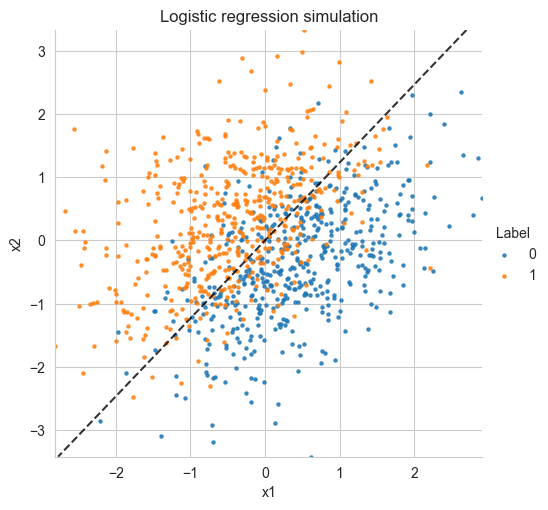

In [7]:
def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z
    
xlim  = [np.min(X[:,0]), np.max(X[:,0])]
ylim  = [np.min(X[:,1]), np.max(X[:,1])]
xplot = np.linspace(xlim[0], xlim[1], 30)
yplot = np.linspace(ylim[0], ylim[1], 30)

Yplot, Xplot = np.meshgrid(yplot, xplot)
xy           = np.vstack([Xplot.ravel(), Yplot.ravel()]).T
P            = decision_function(xy,w0).reshape(Xplot.shape)

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

# plot decision boundary and margins
plt.contour(Xplot, Yplot, P, colors = 'k', levels = [0.5], alpha = 0.8, linestyles = ['--']);

### <font color=darkred>  Logistic regression: losses and gradients </font>

The aim of this section is to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features.

$$
f: w \mapsto \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \{-y_ix^\top_iw + \log(1 + \exp(x_i^\top w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.
 
A basic gradient descent algorithm requires to compute the functions $f$ and $\nabla f$.

<font color=darkred>  Write the likelihood of the logistic regression model and its gradient. You can build a class Logistic Regression which allows to compute the loss function and its gradient.</font>

In [8]:
class LogisticRegression:
    def __init__(self, X, y, lmbd):
        self.X = X
        self.y = y
        self.lmbd = lmbd
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        # Computes f(w)
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += np.log(1+np.exp(X[k].dot(w))) - y[k]*X[k].dot(w)
        res = res/n_samples
        res += lmbd*0.5*(norm(w)**2)
        return res
    
    def grad(self, w):
        # Computes the gradient of f at w
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += -y[k]*X[k] + X[k]*np.exp(X[k].dot(w))/(1+np.exp(X[k].dot(w)))
        res = res/n_samples
        res += lmbd*w
        return res  

    def grad_fi(self, i, w):
        # Computes the gradient of f_i at w
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = -y[i]*X[i] + X[i]*np.exp(X[i].dot(w))/(1+np.exp(X[i].dot(w)))
        res += lmbd*w
        return res 

In [9]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function simu_logreg to simulate data according to the logistic regression model
n_features = 5
w_true     = np.random.randn(n_features)
X, y       = sample_logistic(w_true, n_samples, corr=0.1)
model      = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
check_grad(model.loss, model.grad, w_true)

1.9768679303565353e-07

### <font color=darkred> Gradient descent </font>

In the case of machine/deep learning applications, the function to be minimized is of the form:
$$
f:w\mapsto  \frac{1}{n}\sum_{i=1}^n \ell(Y_i, \langle w; X_i \rangle) + \lambda g(w) = \frac{1}{n}\sum_{i=1}^n f_i(w)\,.
$$
The most simple method  is based on full gradients, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the whole dataset. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum. 
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

<font color=darkred>  Write a gradient descent function with inputs: a logistic regression model, an initial estimate, and a maximum number of iterations and a step-size.</font>

In [10]:
def gd(model, w0, n_iter,step):
    loss_val = np.zeros(n_iter+1)
    w        = w0.copy()
    for k in range(n_iter + 1):
        w    = w - step*model.grad(w)
        loss_val[k] = model.loss(w)
    return w, loss_val

<font color=darkred>  Run the algorithm and display the loss along iterations. Display the impact of the choice of the stepsize.</font>

In [11]:
step_sgd   = 1e-1
w0         = np.random.randn(n_features)
n_iter_max = 500

w, gd_loss  = gd(model, w0, n_iter = n_iter_max, step = step_sgd)

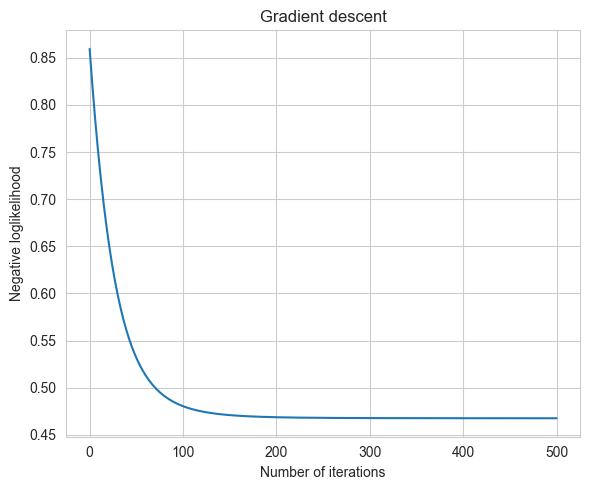

In [12]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-')
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

<font color=darkred>  Adapt the previous gradient descent algorithm to design a stochastic gradient descent with inputs: a logistic regression model, an initial estimate, and a maximum number of iterations, a constant c and a rate alpha (the stepsize at iteration $k$ is $\mathrm{c}/k^\alpha$).</font>

In [13]:
model = LogisticRegression(X, y, 1e-3)

In [14]:
def sgd(model, w0, n_iter, c, alpha):  
    loss_val  = np.zeros(n_iter)
    w = w0.copy()
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = np.random.randint(0, model.n_samples)
        w = w - c * model.grad_fi(i,w) / ((idx+1)**alpha)
        loss_val[idx] = model.loss(w)
    return w, loss_val

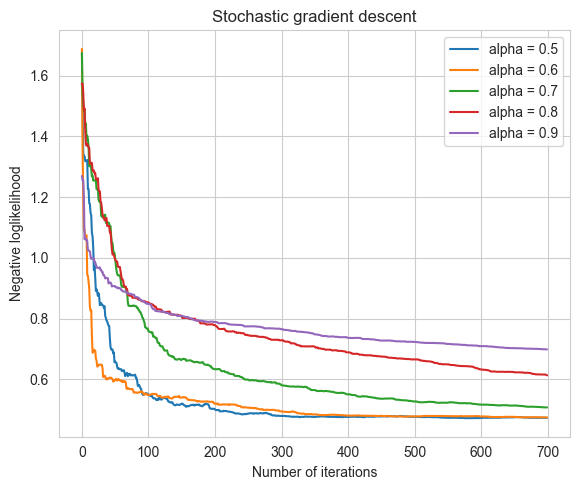

In [15]:
figure = plt.figure(figsize = (6, 5))
plt.title('Stochastic gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

step_gd = [1e-2,1e-1,5e-1,1,2]
stp     = 0.5
alpha   = [0.5,0.6,0.7,0.8,0.9]
w0 = np.random.randn(n_features)
n_iter_max = 700
for al in alpha:
    w, sgd_loss = sgd(model, w0,n_iter_max, stp, al)
    plt.plot(sgd_loss, '-', label='alpha = %.1f' % al)
plt.legend()

### <font color=darkred> ROC curve and AUC</font>

In [16]:
n_test = int(0.2*n_samples)
X_test, y_test = sample_logistic(w_true, n_samples = n_test, corr = 0.8)

In [17]:
# predicted class using the estimated model
y_pred = y_test.copy()
for i in range(n_test):
    if X_test[i].dot(w)>0:
        y_pred[i] = 1.0
    else:
        y_pred[i] = 0.0
print('Mean prediction error with the estimated parameter: %f'%np.mean(np.abs(y_pred-y_test)))

Mean prediction error with the estimated parameter: 0.435000


In [18]:
# predicted probability for each new individual using the estimated model
y_score = np.zeros(n_test)
for i in range(n_test):
    y_score[i] = sigmoid(X_test[i].dot(w))

The Receiver Operating Characteristic (ROC) curve assesses the diagnostic ability of the classifier  as the classification threshold is modified. Logistic regression models the distribution of $Y$ given $X$ as

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}

and the Bayes classifier is defined as 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > \mathbb{P}(Y = 0| X)$,

which is equivalent to 

$f^*(X) = 1$ if and only if $\langle w,X \rangle + b>0$,

or also to 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) >1/2$. 

Therefore, the theoretical threshold to classify individuals is $1/2$. However, analyzing the sensitivity of the classifier to this threshold may be interesting which is the aim of the ROC curve which displays the True positive rate as a function of the False positive rate when the threshold is changed. For each value $p^*\in(0,1)$ the ROC curve classifies individuals using

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > p^*$

and plots the True positive rate as a function of the False positive rate. 

Depending on the application, an optimal threshold may then be used to obtain satisfying True and False positive rates on the test data set.

<font color=darkred>  Use the roc_curve metric from sklearn to display the ROC curve of your logistic regression model.</font>

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
thresholds

array([ inf, 0.99, 0.97, 0.95, 0.95, 0.94, 0.94, 0.94, 0.92, 0.91, 0.91,
       0.89, 0.89, 0.88, 0.87, 0.87, 0.86, 0.84, 0.83, 0.8 , 0.79, 0.79,
       0.76, 0.76, 0.75, 0.75, 0.74, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.66, 0.66, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61,
       0.59, 0.58, 0.57, 0.57, 0.56, 0.56, 0.55, 0.54, 0.54, 0.51, 0.5 ,
       0.48, 0.45, 0.43, 0.42, 0.39, 0.38, 0.37, 0.34, 0.34, 0.34, 0.34,
       0.33, 0.33, 0.32, 0.3 , 0.29, 0.29, 0.29, 0.27, 0.26, 0.25, 0.24,
       0.23, 0.21, 0.2 , 0.19, 0.19, 0.17, 0.17, 0.17, 0.15, 0.15, 0.12,
       0.11, 0.11, 0.07, 0.06, 0.06, 0.02])

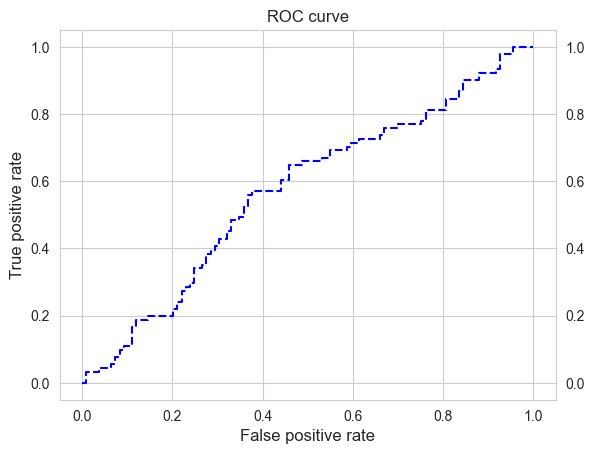

In [20]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(fpr,tpr,linestyle = "dashed",color="blue")
plt.title('ROC curve')
plt.ylabel('True positive rate', fontsize=12)
plt.xlabel('False positive rate', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

In [21]:
print('The area under the ROC curve (AUC) is: %f'%metrics.auc(fpr, tpr))

The area under the ROC curve (AUC) is: 0.572033


## <font color=darkred> Softmax regression </font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model \textbf{weights} and \textbf{intercepts} for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood.

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

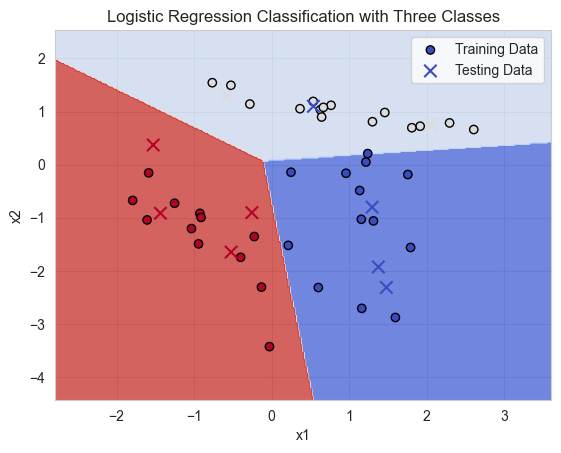

In [23]:
# Generate synthetic data with a Gaussian distribution and three classes
X, y = make_classification(n_samples=50, n_features=2, n_classes=3, n_clusters_per_class=1, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Plot the decision boundaries
h = .02 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', s=80, label='Testing Data')

plt.title('Logistic Regression Classification with Three Classes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()